# Deep Reinforcement Learning for Portfolio Optimization - MLP Architecture


This experiement demonstrates the application of deep reinforcement learning (DRL) techniques for portfolio optimization.

- Policy network architecture: **MLP backbone**
- Compares `A2C`, `PPO`, `SAC`, `DDPG`, `TD3` all with simple MLPs

## Dependencies


In [1]:
# ! pip install pandas numpy matplotlib \
#                stable-baselines3 \
#                PyPortfolioOpt \
#                pandas_market_calendars quantstats gymnasium \
#                git+https://github.com/AI4Finance-Foundation/FinRL.git -q

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import time

import torch

from stable_baselines3 import A2C, PPO, SAC, DDPG, TD3
from stable_baselines3.common.noise import NormalActionNoise

from finrl import config
from finrl import config_tickers
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_portfolio_allocation.env_portfolio import StockPortfolioEnv
from finrl.agents.stablebaselines3.models import DRLAgent, DRLEnsembleAgent
from finrl.plot import backtest_stats, get_daily_return, get_baseline, backtest_plot

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models

/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/pyfolio/pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [3]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

%matplotlib inline

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [ ]:
experiment_name = "mlp_5_models"
results_dir = f"results/models/{experiment_name}"
os.makedirs(results_dir, exist_ok=True)

## Data loading and pre-processing


Define training and trading/test periods


In [6]:
start_date = "2015-01-01"
end_date = (datetime.now() - pd.Timedelta(days=1)).strftime("%Y-%m-%d")  # Yesterday

trade_period = 2  # 2 years for testing
train_period = 10  # 10 years for training

train_end_date = (
    datetime.strptime(end_date, "%Y-%m-%d") - timedelta(days=trade_period * 365)
).strftime("%Y-%m-%d")
train_start_date = (
    datetime.strptime(train_end_date, "%Y-%m-%d") - timedelta(days=train_period * 365)
).strftime("%Y-%m-%d")
test_start_date = (
    datetime.strptime(train_end_date, "%Y-%m-%d") + timedelta(days=1)
).strftime("%Y-%m-%d")

train_dates = (train_start_date, train_end_date)
test_dates = (test_start_date, end_date)

print(f"Training period: {train_dates}")
print(f"Testing period: {test_dates}")

Training period: ('2013-05-05', '2023-05-03')
Testing period: ('2023-05-04', '2025-05-02')


- Fetch historical stock data for a given list of tickers within a specified date range.
- We use the DOW_30_TICKER stocks
- The data includes `date`, `close`, `high`, `low`, `open`, `volume`, and `tic` (ticker symbol).


In [7]:
def download_data(tickers, start_date, end_date):
    print(f"Downloading {start_date} → {end_date}")
    return YahooDownloader(
        start_date=start_date, end_date=end_date, ticker_list=tickers
    ).fetch_data()


df = download_data(config_tickers.DOW_30_TICKER, start_date, end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Shape of DataFrame:  (76881, 8)


==========

We apply feature engineering to the dataset of stock data:

- Add technical indicators (e.g., moving averages, RSI).
- Calculate turbulence indicators, which measure market volatility.

This Enhance the dataset with features that are critical for modeling market dynamics and making informed trading decisions.


In [8]:
def preprocess_data(df):
    fe = FeatureEngineer(use_technical_indicator=True, use_turbulence=True)
    return fe.preprocess_data(df)


df_feat = preprocess_data(df)

# TODO: Normalise the data??

Successfully added technical indicators
Successfully added turbulence index


## Covariance & Returns for State


- Calculate the rolling covariance matrices and daily returns for the given dataset of stock prices.
- This prepares the state representation (the state of the portfolio) for the RL models in the RL environments for portfolio optimization.
- The **rolling covariance matrices** (`cov_list`) capture the relationships between asset returns, while the daily returns (`return_list`) provide information about recent price movements.
- These metrics are critical for modeling the dynamics of the financial market and making informed trading decisions.


In [9]:
def compute_covariance_and_returns(df_feat, lookback=252):
    df_sorted = df_feat.sort_values(["date", "tic"], ignore_index=True)
    df_sorted.index = df_sorted.date.factorize()[0]
    cov_list, return_list = [], []

    dates = df_sorted.date.unique()
    for i in range(lookback, len(dates)):
        win = df_sorted.loc[i - lookback : i]
        pm = win.pivot_table(index="date", columns="tic", values="close")
        rm = pm.pct_change().dropna()
        cov_list.append(rm.cov().values)
        return_list.append(rm)
    df_cov = pd.DataFrame(
        {"date": dates[lookback:], "cov_list": cov_list, "return_list": return_list}
    )

    return pd.merge(df_feat, df_cov, on="date", how="left").dropna(subset=["cov_list"])


df_all = compute_covariance_and_returns(df_feat)

## Train/Trade split


In [10]:
def split_data(df_all, train_dates, test_dates):
    train = data_split(df_all, *train_dates)
    test = data_split(df_all, *test_dates)
    return train, test


train, test = split_data(df_all, train_dates, test_dates)

## Environment setup


- Create instances of the StockPortfolioEnv class for both training and testing datasets.
- It also wrap the training environment for use with Stable-Baselines3 (SB3).


In [11]:
def configure_environment(train, test, fe):
    stock_dim = len(train.tic.unique())
    env_kwargs = dict(
        stock_dim=stock_dim,  # Number of unique stocks
        hmax=100,  # Maximum number of shares that can be traded
        initial_amount=1e6,  # Initial portfolio value (e.g., $1,000,000)
        transaction_cost_pct=0.001,  # Transaction cost as a percentage (e.g., 0.1%)
        reward_scaling=1e-4,  # Scaling factor for rewards
        state_space=stock_dim,  # State space dimension (equal to stock_dim)
        action_space=stock_dim,  # Action space dimension (equal to stock_dim)
        tech_indicator_list=fe.tech_indicator_list,  # List of technical indicators
    )

    # create the two StockPortfolioEnv objects
    raw_train_env = StockPortfolioEnv(df=train, **env_kwargs)
    raw_test_env = StockPortfolioEnv(df=test, **env_kwargs)

    # Wrap the *training* env for SB3
    env_train_sb3, _ = raw_train_env.get_sb_env()

    return env_train_sb3, raw_train_env, raw_test_env, env_kwargs


env_train_sb3, raw_train_env, raw_test_env, env_kwargs = configure_environment(
    train, test, FeatureEngineer()
)

## Training


- We define the configuration for various RL models to be trained in the portfolio optimization environment.
- The training environment (`env_train_sb3`) is wrapped for use with Stable-Baselines3 (SB3).
- The SB3 environment provides the `state` and `action space` dimensions needed for configuring the models.


In [33]:
def prepare_models(env_train_sb3):
    n_actions = env_train_sb3.action_space.shape[-1]
    action_noise = NormalActionNoise(
        mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions)
    )
    model_configs = [
        (A2C, "A2C", {}),
        (PPO, "PPO", {}),
        (SAC, "SAC", {}),
        (DDPG, "DDPG", {"action_noise": action_noise}),
        (TD3, "TD3", {"action_noise": action_noise}),
    ]
    return model_configs


model_configs = prepare_models(env_train_sb3)

Train multiple reinforcement learning (RL) models using the specified training environment and configuration.


In [34]:
def train_models(env_train_sb3, model_configs, save_dir, timesteps=200_000):
    models, training_times = {}, {}

    for cls, name, kwargs in model_configs:
        print(f"Training {name}...")
        start_time = time.time()
        model = cls("MlpPolicy", env_train_sb3, verbose=0, **kwargs)
        model.learn(total_timesteps=timesteps)
        end_time = time.time()
        training_times[name] = (end_time - start_time) / 60
        models[name] = model
        model.save(f"{save_dir}/{name}_mlp_model")
        print(f"{name} training completed in {training_times[name]:.2f} minutes.")

    return models, training_times

In [35]:
models, training_times = train_models(env_train_sb3, model_configs, results_dir, timesteps=200_000)

Training A2C...
begin_total_asset:1000000.0
end_total_asset:2554277.999656884
Sharpe:  0.7857398240908697
begin_total_asset:1000000.0
end_total_asset:2455825.9421072025
Sharpe:  0.7638016064662463
begin_total_asset:1000000.0
end_total_asset:2468320.356123102
Sharpe:  0.7651814954472667
begin_total_asset:1000000.0
end_total_asset:2514777.458123699
Sharpe:  0.779687403398517
begin_total_asset:1000000.0
end_total_asset:2356835.5483447607
Sharpe:  0.7346476763644219
begin_total_asset:1000000.0
end_total_asset:2577015.10049785
Sharpe:  0.7924892608705011
begin_total_asset:1000000.0
end_total_asset:2486896.541240079
Sharpe:  0.7682988748286639
begin_total_asset:1000000.0
end_total_asset:2399038.08602424
Sharpe:  0.7361267416440169
begin_total_asset:1000000.0
end_total_asset:2391992.054858114
Sharpe:  0.7325813552675636
begin_total_asset:1000000.0
end_total_asset:2535405.4041768815
Sharpe:  0.7805121729447999
begin_total_asset:1000000.0
end_total_asset:2399426.316966712
Sharpe:  0.74881668549

/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/stable_baselines3/common/buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 8.71GB > 4.43GB
  warnings.warn(


begin_total_asset:1000000.0
end_total_asset:2568539.201781534
Sharpe:  0.7822910758229619
begin_total_asset:1000000.0
end_total_asset:2565708.4334137486
Sharpe:  0.7814552594279115
begin_total_asset:1000000.0
end_total_asset:2565979.489417086
Sharpe:  0.7815194129647449
begin_total_asset:1000000.0
end_total_asset:2566533.2476173234
Sharpe:  0.7816995665856656
begin_total_asset:1000000.0
end_total_asset:2565110.2631780338
Sharpe:  0.7812980527852841
begin_total_asset:1000000.0
end_total_asset:2565439.5734306737
Sharpe:  0.781420518939865
begin_total_asset:1000000.0
end_total_asset:2564380.968750767
Sharpe:  0.7811256011051195
begin_total_asset:1000000.0
end_total_asset:2566796.0019719144
Sharpe:  0.781846495625738
begin_total_asset:1000000.0
end_total_asset:2566696.6064739428
Sharpe:  0.7819263121949502
begin_total_asset:1000000.0
end_total_asset:2565542.3310233606
Sharpe:  0.781557924287037
begin_total_asset:1000000.0
end_total_asset:2563001.0514560244
Sharpe:  0.7809072241526213
begin

/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/stable_baselines3/common/buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 8.71GB > 4.88GB
  warnings.warn(


begin_total_asset:1000000.0
end_total_asset:2536350.8553509237
Sharpe:  0.7774279627421778
begin_total_asset:1000000.0
end_total_asset:2498262.378640604
Sharpe:  0.7656894663350858
begin_total_asset:1000000.0
end_total_asset:2500837.7781957756
Sharpe:  0.7664097358992938
begin_total_asset:1000000.0
end_total_asset:2504245.1865511523
Sharpe:  0.7673938181949617
begin_total_asset:1000000.0
end_total_asset:2497483.1285434496
Sharpe:  0.7655790669258032
begin_total_asset:1000000.0
end_total_asset:2490917.0461758357
Sharpe:  0.7633952133584883
begin_total_asset:1000000.0
end_total_asset:2507511.8303278154
Sharpe:  0.7681335934428072
begin_total_asset:1000000.0
end_total_asset:2507585.8402673346
Sharpe:  0.7685962855072076
begin_total_asset:1000000.0
end_total_asset:2508746.779563878
Sharpe:  0.7688162381702769
begin_total_asset:1000000.0
end_total_asset:2487093.3709665583
Sharpe:  0.7626291428733857
begin_total_asset:1000000.0
end_total_asset:2477419.1520313304
Sharpe:  0.7593099669126591
b

/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/stable_baselines3/common/buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 8.71GB > 4.64GB
  warnings.warn(


begin_total_asset:1000000.0
end_total_asset:2277194.150368515
Sharpe:  0.7287677557595561
begin_total_asset:1000000.0
end_total_asset:2302896.3532813177
Sharpe:  0.7390805607846906
begin_total_asset:1000000.0
end_total_asset:2313136.2250762684
Sharpe:  0.7421595967180956
begin_total_asset:1000000.0
end_total_asset:2305579.992491001
Sharpe:  0.7392860435108044
begin_total_asset:1000000.0
end_total_asset:2303780.7027752735
Sharpe:  0.7393010910041115
begin_total_asset:1000000.0
end_total_asset:2305431.646180723
Sharpe:  0.7394980134897241
begin_total_asset:1000000.0
end_total_asset:2300404.444228737
Sharpe:  0.7382665833476897
begin_total_asset:1000000.0
end_total_asset:2298379.034590432
Sharpe:  0.7369331695610933
begin_total_asset:1000000.0
end_total_asset:2311092.1611076226
Sharpe:  0.7414384910813134
begin_total_asset:1000000.0
end_total_asset:2311736.153437862
Sharpe:  0.7418338175411362
begin_total_asset:1000000.0
end_total_asset:2307727.416540285
Sharpe:  0.7403084481584749
begin_

In [36]:
training_times_df = pd.DataFrame(
    list(training_times.items()), columns=["model", "training_duration (min)"]
)

training_times_df.to_csv(f"{results_dir}/training_times.csv", index=False)

print("Training summary:")
display(training_times_df)

Training summary:


model  training_duration (min)
0   A2C                 5.899591
1   PPO                 4.850560
2   SAC               115.740727
3  DDPG                77.083322
4   TD3                86.108583

## Model loading


Load the trained models from memory for analysis without the need for time consuming retraining


In [37]:
def load_models(model_configs, results_dir):
    models = {}
    for _, name, _ in model_configs:
        model_path = f"{results_dir}/{name}_mlp_model.zip"
        if os.path.exists(model_path):
            print(f"Loading saved model for {name}...")
            models[name] = globals()[name].load(model_path)
        else:
            print(f"No saved model found for {name}.")
    return models


# models = load_models(model_configs, results_dir)

## Backtesting


- Evaluates the performance of the RL models/algorithms in a trading environment.
- We do this by calculating the **cumulative portfolio value** and **performance metrics** for each RL model.


In [38]:
def backtest_rl_strategies(models, raw_env, env_kwargs):
    results = {}
    for name, model in models.items():
        print(f"Backtesting {name}…")
        # Simulate trading using the model in the raw_env environment
        df_ret, _ = DRLAgent.DRL_prediction(
            model=model, environment=raw_env, deterministic=True
        )
        df_ret["account_value"] = (df_ret.daily_return + 1).cumprod() * env_kwargs[
            "initial_amount"
        ]
        stats = backtest_stats(df_ret, value_col_name="account_value")
        results[name] = {"df": df_ret, "stats": stats}
    return results


results = backtest_rl_strategies(models, raw_test_env, env_kwargs)

Backtesting A2C…
begin_total_asset:1000000.0
end_total_asset:1336653.0088266383
Sharpe:  1.1261287517165366
hit end!
Annual return          0.157480
Cumulative returns     0.336653
Annual volatility      0.138503
Sharpe ratio           1.127260
Calmar ratio           1.070222
Stability              0.874927
Max drawdown          -0.147147
Omega ratio            1.229402
Sortino ratio          1.675220
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.096047
Daily value at risk   -0.016830
dtype: float64
Backtesting PPO…
begin_total_asset:1000000.0
end_total_asset:1259745.0104388355
Sharpe:  0.9286602733309931
hit end!
Annual return          0.123421
Cumulative returns     0.259745
Annual volatility      0.135263
Sharpe ratio           0.929592
Calmar ratio           0.839389
Stability              0.865293
Max drawdown          -0.147036
Omega ratio            1.186784
Sortino ratio          1.375627
Skew                        NaN
Kurtosis       

### Plotting


[*********************100%***********************]  1 of 1 completed

Plotting A2C…
Shape of DataFrame:  (500, 8)


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/matplotlib/dates.py:449: UserWarning: no explicit representation of timezones available for np.datetime64
  d = d.astype('datetime64[us]')
/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/pyfolio/plotting.py:1407: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Daily", "Weekly", "Monthly"])


[*********************100%***********************]  1 of 1 completed

Plotting PPO…
Shape of DataFrame:  (500, 8)


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/matplotlib/dates.py:449: UserWarning: no explicit representation of timezones available for np.datetime64
  d = d.astype('datetime64[us]')
/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/pyfolio/plotting.py:1407: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Daily", "Weekly", "Monthly"])


[*********************100%***********************]  1 of 1 completed

Plotting SAC…
Shape of DataFrame:  (500, 8)


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/matplotlib/dates.py:449: UserWarning: no explicit representation of timezones available for np.datetime64
  d = d.astype('datetime64[us]')
/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/pyfolio/plotting.py:1407: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Daily", "Weekly", "Monthly"])


[*********************100%***********************]  1 of 1 completed

Plotting DDPG…
Shape of DataFrame:  (500, 8)


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/matplotlib/dates.py:449: UserWarning: no explicit representation of timezones available for np.datetime64
  d = d.astype('datetime64[us]')
/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/pyfolio/plotting.py:1407: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Daily", "Weekly", "Monthly"])


[*********************100%***********************]  1 of 1 completed

Plotting TD3…
Shape of DataFrame:  (500, 8)


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/matplotlib/dates.py:449: UserWarning: no explicit representation of timezones available for np.datetime64
  d = d.astype('datetime64[us]')
/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/pyfolio/plotting.py:1407: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Daily", "Weekly", "Monthly"])


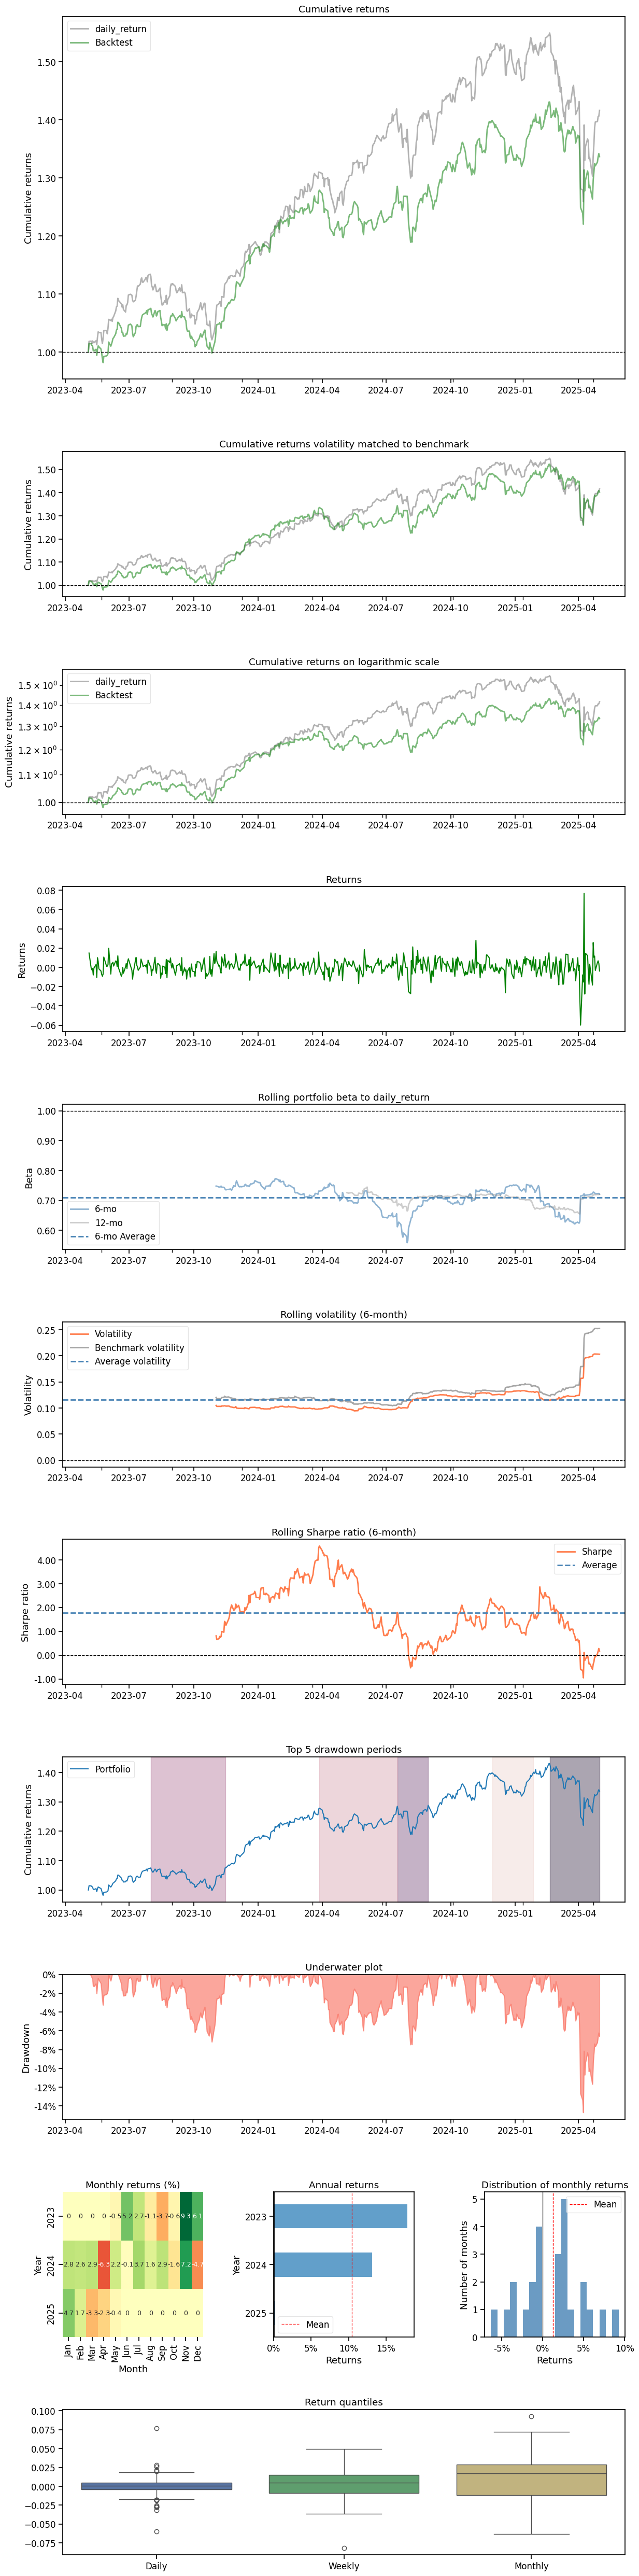

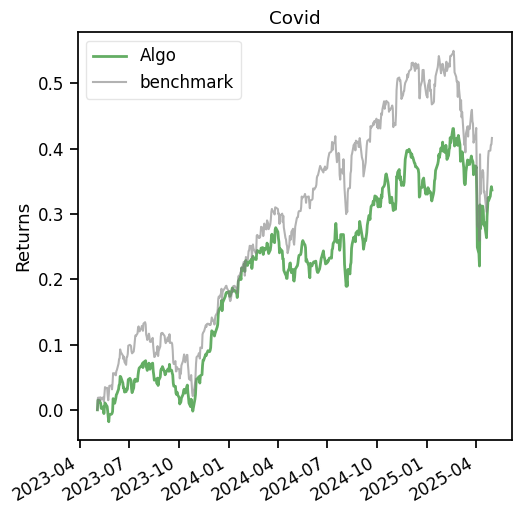

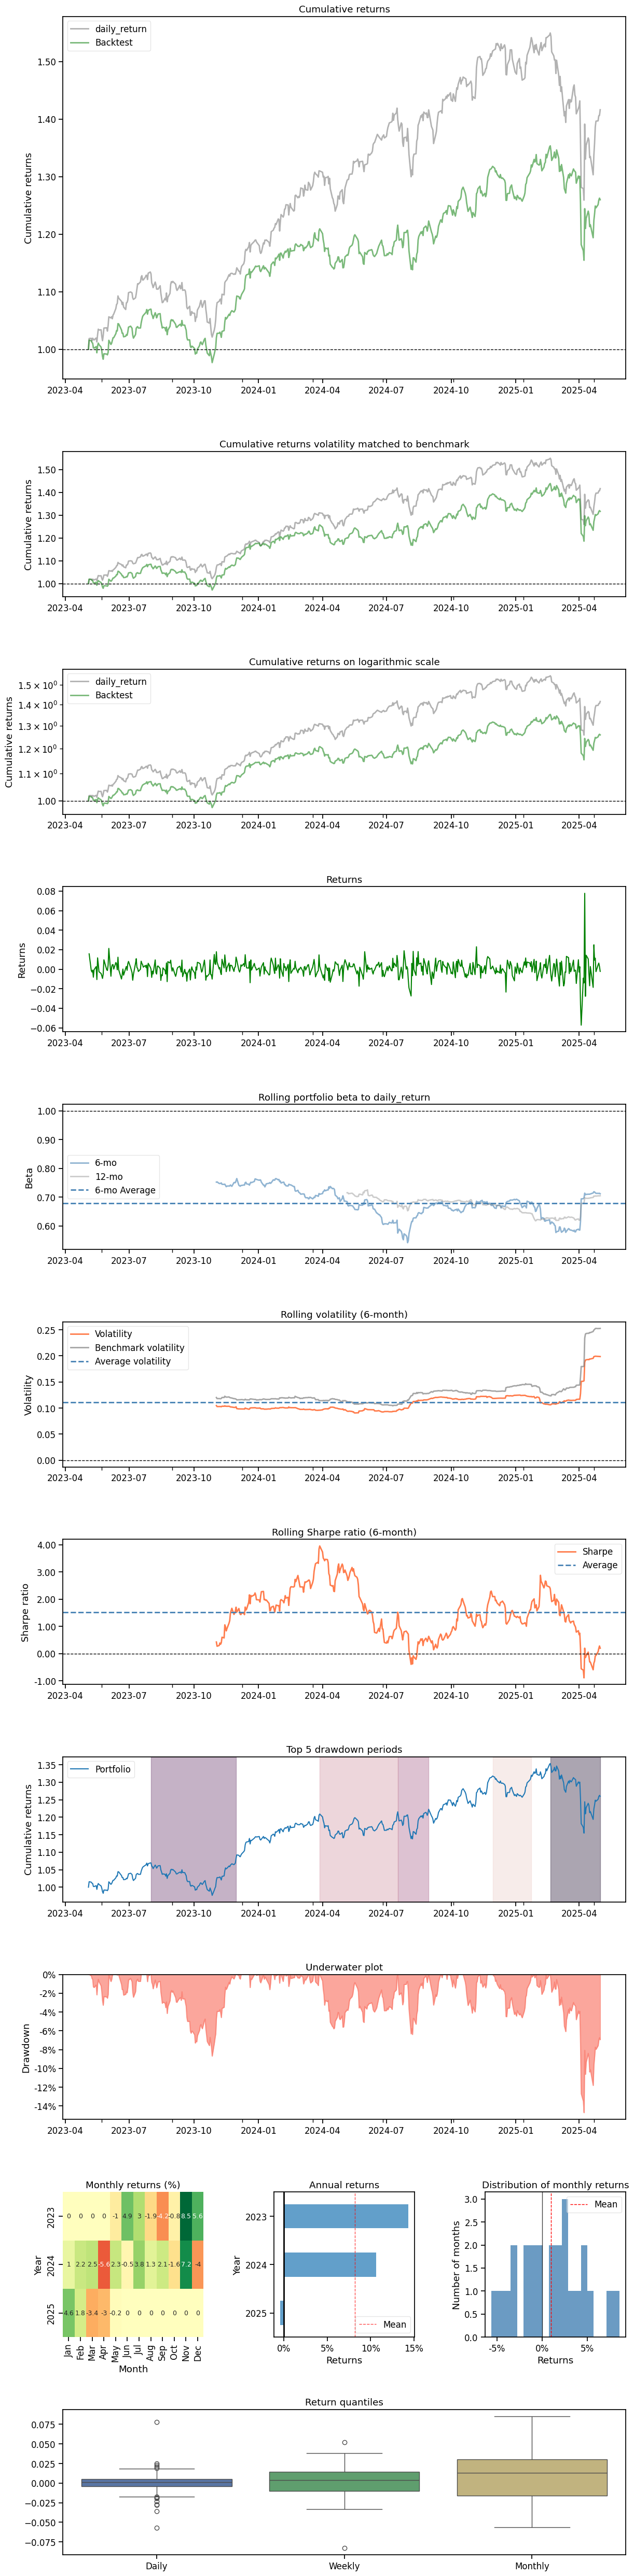

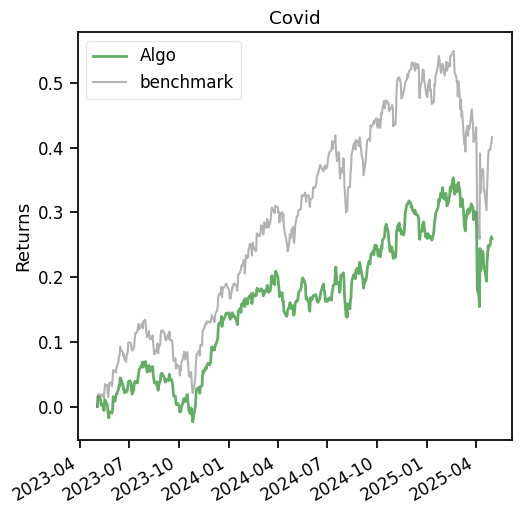

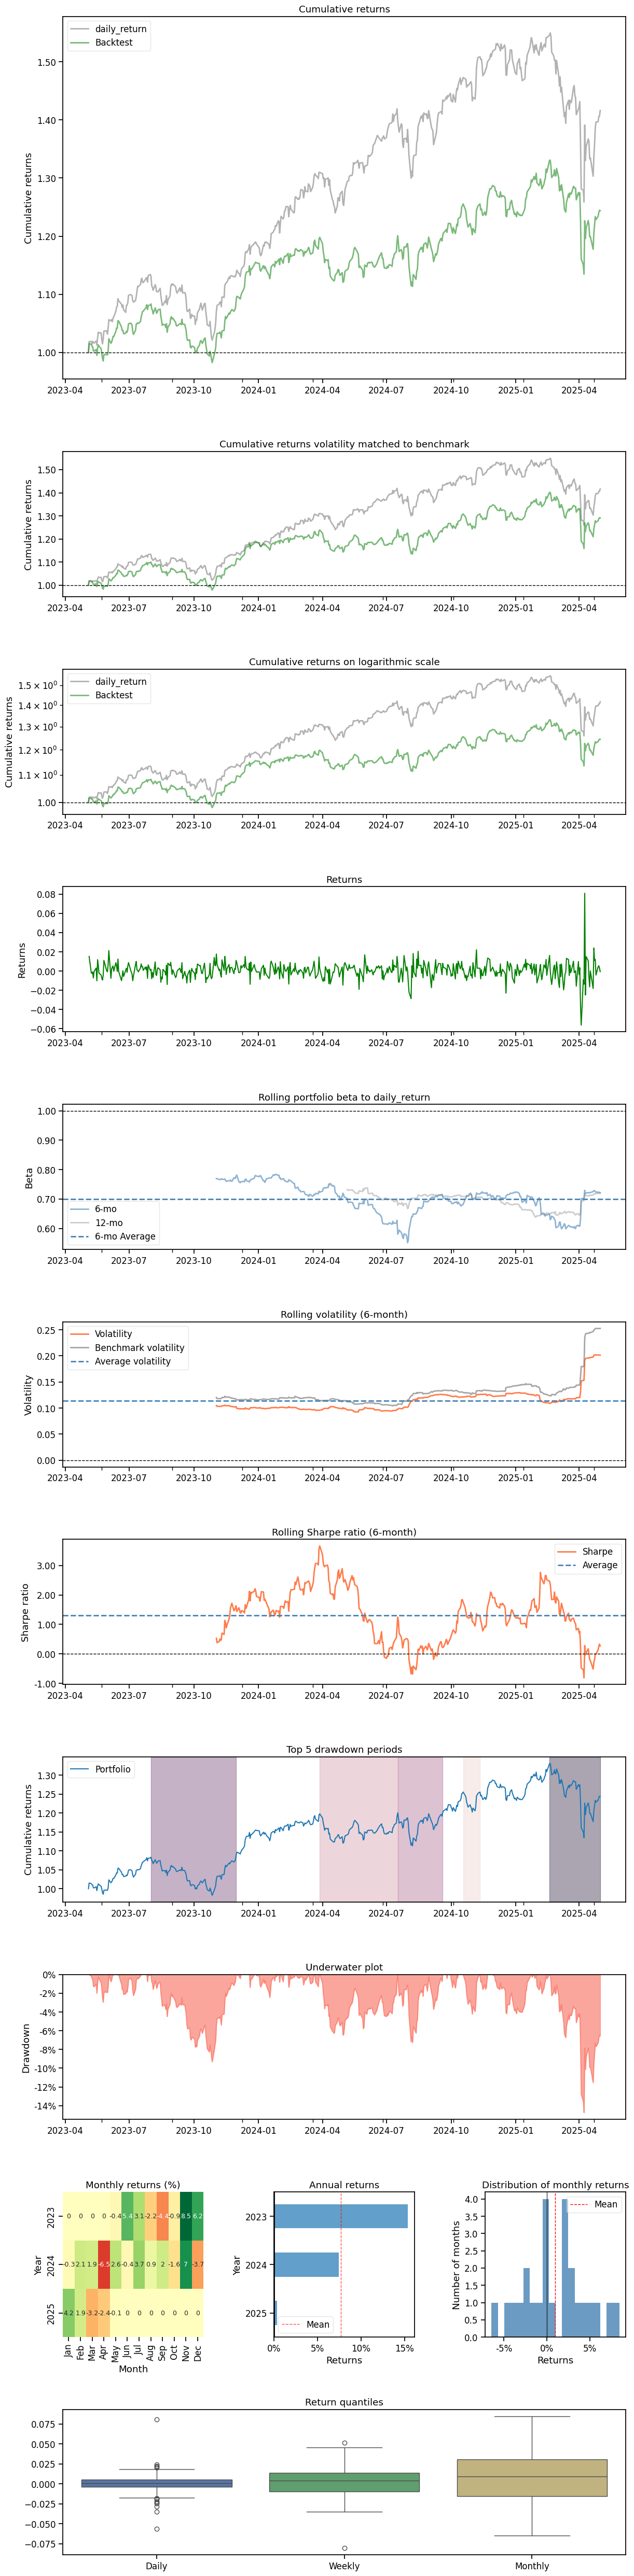

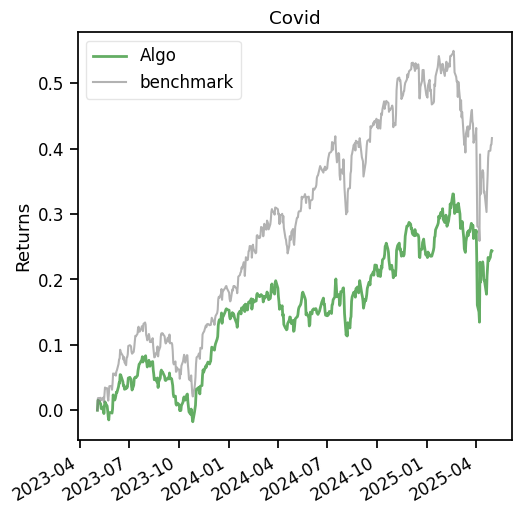

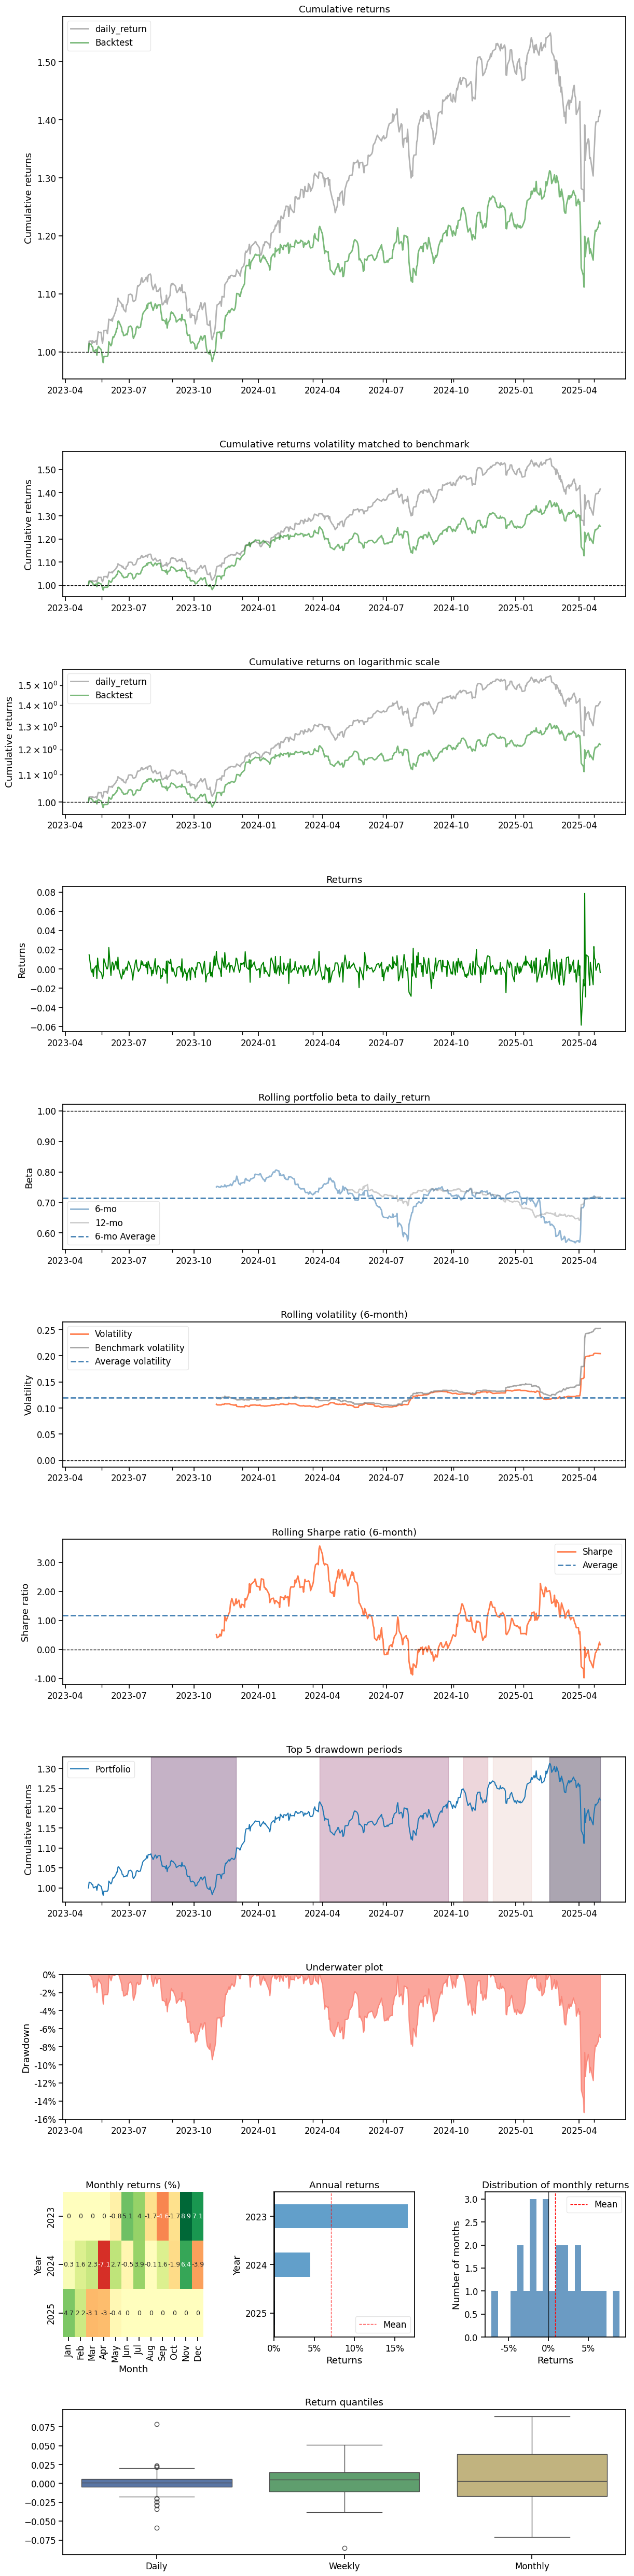

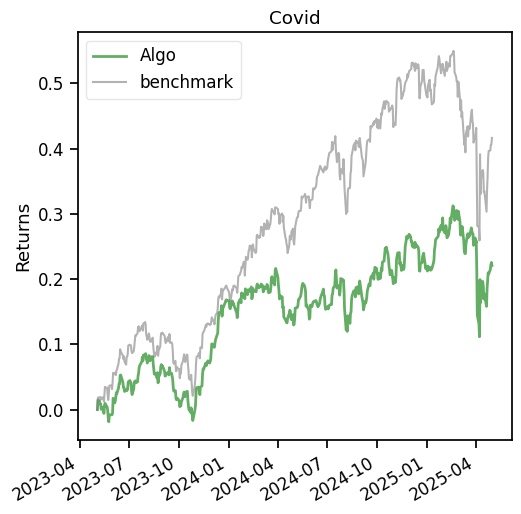

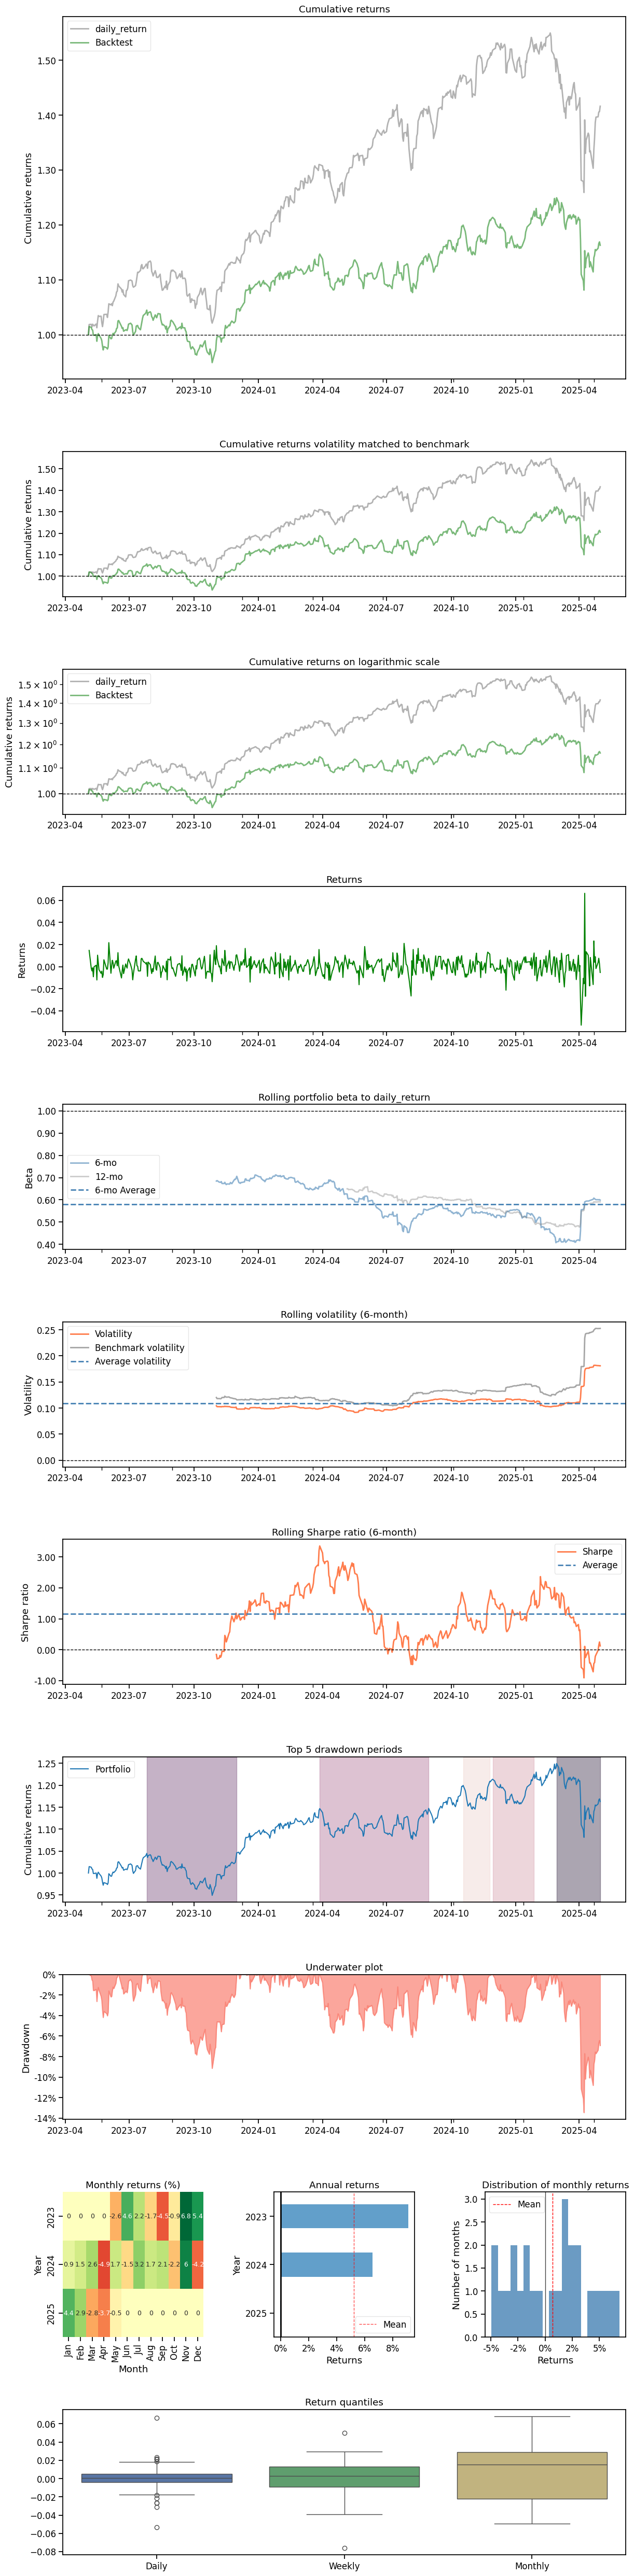

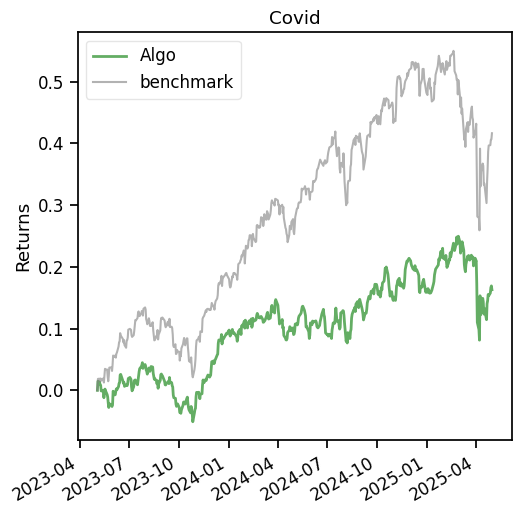

In [39]:
def plot_backtest_results():
    for name, res in results.items():
        print(f"Plotting {name}…")
        backtest_plot(
            account_value=res["df"],
            baseline_start=test_start_date,
            baseline_end=end_date,
            baseline_ticker="SPY",
            value_col_name="account_value",
        )

plot_backtest_results()

## Benchmarks


These benchmarks will provide baseline performance metrics for comparison with the RL strategies.
We evaluate the performance of **Mean-Variance Optimization (MVO)** and simple benchmarks (**Equal-Weighted Portfolio** and **SPY**) in terms of returns, volatility, and cumulative portfolio value.


---

### Mean-Variance Optimization Benchmark

- **Objective**: Calculate the benchmark portfolio using **Mean-Variance Optimization (MVO)**.
- **Purpose**: This function benchmarks the performance of a portfolio optimized for minimum volatility using **Modern Portfolio Theory (MPT)**.
- **Comparison**: It allows us to compare the MPT strategy with other RL strategies by analyzing metrics like returns, volatility, and cumulative performance.

##### Workflow:

1. **Covariance Matrix**:

   - Extract the covariance matrix of asset returns for each trading day in the test period.
   - Use this matrix to model the relationships between asset returns.

2. **Optimization**:

   - Apply **Efficient Frontier** to minimize portfolio volatility.
   - Compute the optimal weights for each asset in the portfolio.

3. **Portfolio Value Calculation**:

   - Calculate the portfolio's account value over time using the optimized weights and asset prices.

4. **Performance Metrics**:
   - Evaluate the portfolio's performance using metrics such as annual return, cumulative return, and volatility.
   - Add the results to the `results` dictionary under the `"MPT"` key.


In [40]:
def compute_mpt_benchmark(test, env_kwargs):
    dates_test = test.date.unique()
    min_vals = [env_kwargs["initial_amount"]]
    for i in range(len(dates_test) - 1):
        curr = test[test.date == dates_test[i]]
        nxt = test[test.date == dates_test[i + 1]]
        covm = np.array(curr.cov_list.values[0])
        ef = EfficientFrontier(None, covm, weight_bounds=(0, 1))
        ef.min_volatility()
        w = ef.clean_weights()
        prices = curr.close.values
        nextp = nxt.close.values
        shares = np.array(list(w.values())) * min_vals[-1] / prices
        min_vals.append(np.dot(shares, nextp))
    min_df = pd.DataFrame({"date": dates_test, "account_value": min_vals})
    stats_mpt = backtest_stats(min_df, value_col_name="account_value")
    return {"df": min_df, "stats": stats_mpt}


mpt_benchmark = compute_mpt_benchmark(test, env_kwargs)

Annual return          0.071678
Cumulative returns     0.147232
Annual volatility      0.110714
Sharpe ratio           0.681851
Calmar ratio           0.684569
Stability              0.846443
Max drawdown          -0.104705
Omega ratio            1.131734
Sortino ratio          0.984245
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.018635
Daily value at risk   -0.013649
dtype: float64


---

### Equal-Weighted Portfolio Benchmark

- Calculate the performance of an **equal-weighted portfolio** benchmark.
- This benchmark assumes that all assets in the portfolio are equally weighted, and their daily returns are averaged to compute the portfolio's overall return.

##### Workflow:

1. **Daily Returns Calculation**:

   - Group the test dataset by `date`.
   - Compute the percentage change (`pct_change`) in the `close` prices for each group.
   - Calculate the mean of the daily percentage changes to represent the portfolio's daily return.

2. **Cumulative Portfolio Value**:

   - Reset the index of the daily returns to create a DataFrame (`ew_df`).
   - Compute the cumulative product of the daily returns (`cumprod`) to calculate the portfolio's cumulative value over time.
   - Multiply the cumulative returns by the initial portfolio value (`initial_amount`) to get the portfolio's account value.

3. **Performance Metrics**:
   - Use the `backtest_stats` function to calculate performance metrics for the equal-weighted portfolio, such as annual return, cumulative return, and volatility.


In [41]:
def compute_equal_weighted_benchmark(df, initial_amount=100_000):
    # Pivot to have one column per ticker
    price_wide = df.pivot_table(
        index="date", columns="tic", values="close"
    ).sort_index()

    # Compute each ticker's daily return, then average equally
    daily_rets = price_wide.pct_change().fillna(0).mean(axis=1)

    # Build the equity curve
    ew_df = pd.DataFrame({"date": daily_rets.index, "daily_return": daily_rets.values})
    ew_df["account_value"] = (ew_df["daily_return"] + 1).cumprod() * initial_amount

    # Compute performance statistics
    stats_ew = backtest_stats(ew_df, value_col_name="account_value")

    return {"df": ew_df.reset_index(drop=True), "stats": stats_ew}


ew_benchmark = compute_equal_weighted_benchmark(test, env_kwargs["initial_amount"])

Annual return          0.123444
Cumulative returns     0.259797
Annual volatility      0.135256
Sharpe ratio           0.929785
Calmar ratio           0.839699
Stability              0.865395
Max drawdown          -0.147010
Omega ratio            1.186852
Sortino ratio          1.375868
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.994492
Daily value at risk   -0.016542
dtype: float64


---

### SPY Benchmark

- **Objective**: Calculate the benchmark performance of the `SPY ETF`, which tracks the **S&P 500** index.
- **Purpose**: This function provides a baseline for comparing the performance of reinforcement learning models and other portfolio strategies.

##### Workflow:

1. **Data Retrieval**:
   - Use the `get_baseline` function to fetch the historical closing prices of the SPY ETF for the test period.
2. **Daily Returns Calculation**:
   - Compute the percentage change (`pct_change`) in the SPY closing prices to calculate daily returns.
3. **Cumulative Portfolio Value**:
   - Create a DataFrame (`spy_df`) with the daily returns and calculate the cumulative product (`cumprod`) of the daily returns to compute the portfolio's cumulative value over time.
   - Multiply the cumulative returns by the initial portfolio value (`initial_amount`) to get the portfolio's account value.
4. **Performance Metrics**:
   - Use the `backtest_stats` function to calculate performance metrics for the SPY benchmark, such as annual return, cumulative return, and volatility.


In [42]:
def compute_spy_benchmark(test, env_kwargs):
    spy_close = get_baseline("SPY", test_start_date, end_date)['close']
    spy_ret = spy_close.pct_change().dropna()
    spy_df = pd.DataFrame({"date": spy_ret.index, "daily_return": spy_ret.values})
    spy_df["account_value"] = (spy_df.daily_return + 1).cumprod() * env_kwargs[
        "initial_amount"
    ]
    stats_spy = backtest_stats(spy_df, value_col_name="account_value")
    return {"df": spy_df, "stats": stats_spy}


spy_benchmark = compute_spy_benchmark(test, env_kwargs)

[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (500, 8)
Annual return          0.181150
Cumulative returns     0.390515
Annual volatility      0.163326
Sharpe ratio           1.102661
Calmar ratio           0.965865
Stability              0.868037
Max drawdown          -0.187552
Omega ratio            1.237216
Sortino ratio          1.637674
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.885882
Daily value at risk   -0.019862
dtype: float64


In [43]:
benchmarks = {
    "MPT": mpt_benchmark,
    "EW": ew_benchmark,
    "SPY": spy_benchmark,
}

results.update(benchmarks)

## Performance Summary


In [47]:
perf_stats = pd.DataFrame({key.upper(): res["stats"] for key, res in results.items()})
display(perf_stats)

A2C       PPO       SAC      DDPG       TD3  \
Annual return        0.157480  0.123421  0.116219  0.105782  0.079011   
Cumulative returns   0.336653  0.259745  0.243771  0.220804  0.162861   
Annual volatility    0.138503  0.135263  0.137572  0.141808  0.128522   
Sharpe ratio         1.127260  0.929592  0.869337  0.781207  0.656996   
Calmar ratio         1.070222  0.839389  0.788425  0.692024  0.586749   
Stability            0.874927  0.865293  0.834016  0.781951  0.815271   
Max drawdown        -0.147147 -0.147036 -0.147406 -0.152859 -0.134659   
Omega ratio          1.229402  1.186784  1.173543  1.152531  1.122975   
Sortino ratio        1.675220  1.375627  1.287283  1.146118  0.957188   
Skew                      NaN       NaN       NaN       NaN       NaN   
Kurtosis                  NaN       NaN       NaN       NaN       NaN   
Tail ratio           1.096047  0.994195  0.961815  0.999556  0.985423   
Daily value at risk -0.016830 -0.016543 -0.016858 -0.017426 -0.015857   

                          MPT        EW       SPY  
Annual return        0.071678  0.123444  0.181150  
Cumulative returns   0.147232  0.259797  0.390515  
Annual volatility    0.110714  0.135256  0.163326  
Sharpe ratio         0.681851  0.929785  1.102661  
Calmar ratio         0.684569  0.839699  0.965865  
Stability            0.846443  0.865395  0.868037  
Max drawdown        -0.104705 -0.147010 -0.187552  
Omega ratio          1.131734  1.186852  1.237216  
Sortino ratio        0.984245  1.375868  1.637674  
Skew                      NaN       NaN       NaN  
Kurtosis                  NaN       NaN       NaN  
Tail ratio           1.018635  0.994492  0.885882  
Daily value at risk -0.013649 -0.016542 -0.019862

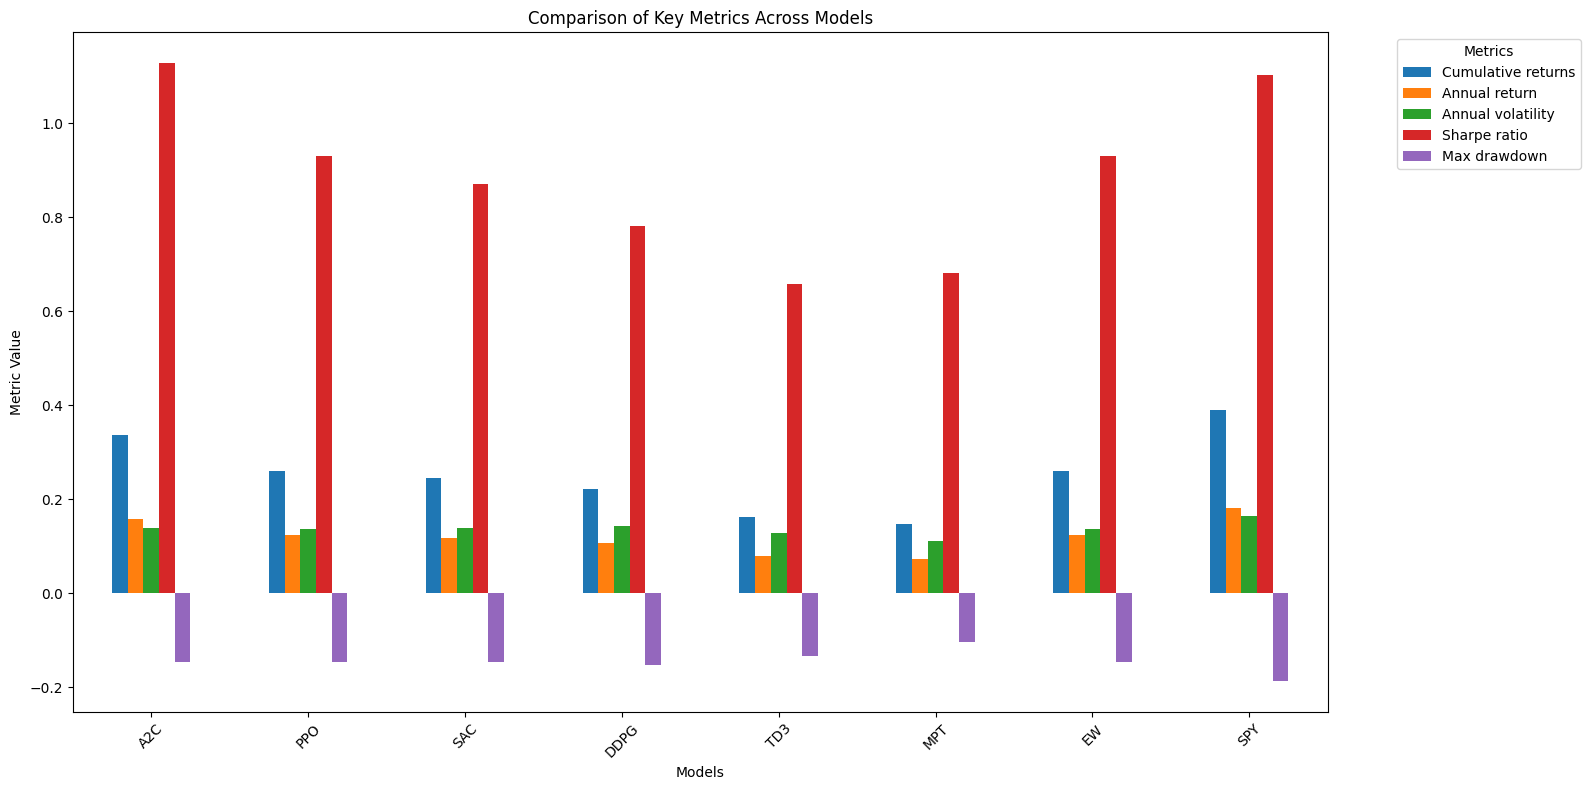

In [45]:
comparison_metrics = [
    "Cumulative returns",
    "Annual return",
    "Annual volatility",
    "Sharpe ratio",
    "Max drawdown",
]

# Filter the performance statistics for the selected metrics
comparison_table = perf_stats.loc[comparison_metrics]


# Plot the comparison metrics as a bar chart
comparison_table.T.plot(kind='bar', figsize=(16, 8))
plt.title("Comparison of Key Metrics Across Models")
plt.ylabel("Metric Value")
plt.xlabel("Models")
plt.xticks(rotation=45)
plt.legend(title="Metrics", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Visualize the cumulative returns of various strategies over time


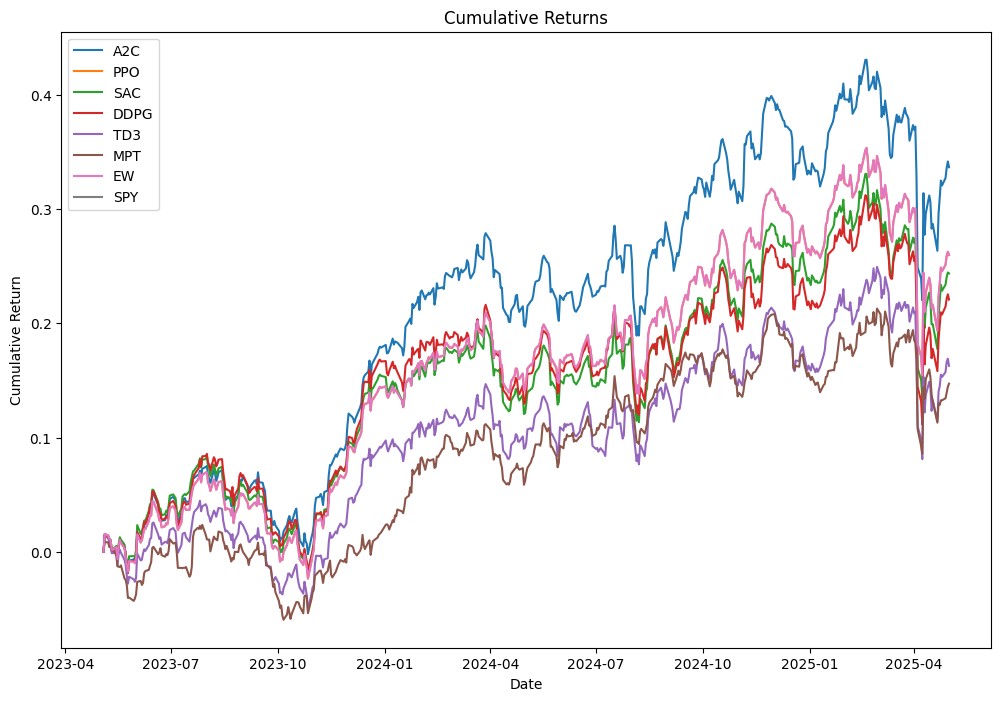

In [46]:
def plot_cumulative_returns(results):
    plt.figure(figsize=(12, 8))
    for name, res in results.items():
        # Ensure the date column is converted to datetime
        res["df"]["date"] = pd.to_datetime(res["df"]["date"])
        # Filter data to start from the trade start date
        filtered_df = res["df"][res["df"]["date"] >= test_start_date]
        cum = (
            (filtered_df["daily_return"] + 1).cumprod() - 1
            if "daily_return" in filtered_df
            else filtered_df["account_value"] / filtered_df["account_value"].iloc[0] - 1
        )
        plt.plot(filtered_df["date"], cum, label=name)
    plt.title("Cumulative Returns")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.show()

plot_cumulative_returns(results)